<h1 style="color: white; 
    font-size: 46px; 
    text-align: center; 
    background: #00ffcc; 
    padding: 30px; 
    ">Text Classification with GloVe</h1>

In [2]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [3]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

# Load the data

- Dataset:  https://www.kaggle.com/kazanova/sentiment140

In [4]:
DATA_URLS = ['https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv']
DIR_NAME = 'sentiments'
    
DATA_FILE_EXT = '.csv'
DATA_DIR_PATH = './data/' + DIR_NAME

In [5]:
# !pip install wget

import os
import wget

def download_wget(URLS, FILE_EXT, DIR_PATH):
    for url in URLS:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(DIR_PATH):
            print('Downloading', url)
            wget.download(url, out=DIR_PATH)
            file_path = os.path.join(DIR_PATH, target_file)
            print('\n \nExtracting files from', file_path)
            print('\nDone!')
        else:
            print('Already downloaded', url)


if not os.path.isdir('data'):
    os.mkdir('data')    
    
if not os.path.isdir('data/' + DIR_NAME):
    os.mkdir('data/' + DIR_NAME)              

    
download_wget(DATA_URLS, DATA_FILE_EXT, DATA_DIR_PATH)

100% [..................................................] 238942690 / 238942690
 
Extracting files from ./data/sentiments\training_cleaned.csv

Done!


In [7]:
corpus = []

num_sentences = 0

with open("./data/sentiments/training_cleaned.csv", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [8]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [9]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [10]:
print(vocab_size)
print(word_index['i'])

138697
1


# The model

- GloVe: Global Vectors for Word Representation https://nlp.stanford.edu/projects/glove/

In [11]:
MODEL_URLS = ['https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt']    
MODEL_FILE_EXT = '.txt'
MODEL_DIR_PATH = './models'    
    
download_wget(MODEL_URLS, MODEL_FILE_EXT, MODEL_DIR_PATH)

100% [..................................................] 347116733 / 347116733
 
Extracting files from ./models\glove.6B.100d.txt

Done!


In [14]:
embeddings_index = {};
with open('./models/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [15]:
print(len(embeddings_matrix))

138698


In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13869800  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,934,953
Trainable params: 65,153
Non-trainable params: 13,869,800
_______________________________________

In [17]:
num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Train on 144000 samples, validate on 16000 samples
Epoch 1/50
144000/144000 - 70s - loss: 0.6136 - accuracy: 0.6533 - val_loss: 0.5721 - val_accuracy: 0.6964
Epoch 2/50
144000/144000 - 67s - loss: 0.5578 - accuracy: 0.7070 - val_loss: 0.5539 - val_accuracy: 0.7088
Epoch 3/50
144000/144000 - 61s - loss: 0.5376 - accuracy: 0.7232 - val_loss: 0.5476 - val_accuracy: 0.7139
Epoch 4/50
144000/144000 - 63s - loss: 0.5258 - accuracy: 0.7307 - val_loss: 0.5444 - val_accuracy: 0.7159
Epoch 5/50
144000/144000 - 61s - loss: 0.5160 - accuracy: 0.7384 - val_loss: 0.5396 - val_accuracy: 0.7188
Epoch 6/50
144000/144000 - 66s - loss: 0.5097 - accuracy: 0.7438 - val_loss: 0.5353 - val_accuracy: 0.7270
Epoch 7/50
144000/144000 - 63s - loss: 0.5031 - accuracy: 0.7473 - val_loss: 0.5361 - val_accuracy: 0.7243
Epoch 8/50
144000/144000 - 62s - loss: 0.4979 - accuracy: 0.7518 - val_loss: 0.5379 - val_accuracy: 0.7270
Epoch 9/50
144000/144000 - 59s - loss: 0.4946 - accuracy: 0.7542 - val_loss: 0.5366 - val_acc

# Plot the results

<Figure size 432x288 with 0 Axes>

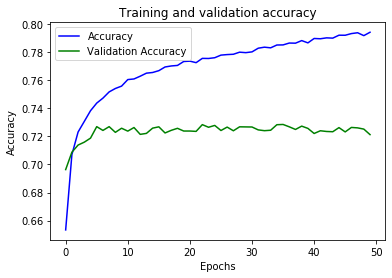

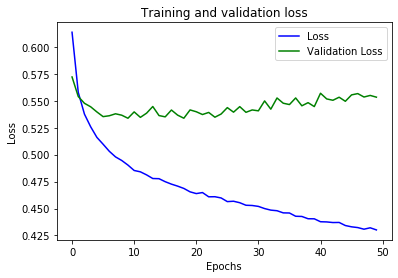

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt


# Retrieve the results on training and test data sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'g')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'g')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()